In [36]:
#Import libraries
import pandas as pd
import numpy as np

#Data Management
import joblib

#Training
import xgboost as xgb

# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler

#Visualization
import matplotlib.pyplot as plt

In [38]:
df = joblib.load('data/df_processed_2.pkl')

In [39]:
df.drop(columns=['id'],inplace=True)

target = df.pop('price')

In [10]:
# split our data
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2)


In [11]:
# scale data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [16]:
# create a baseline
booster = xgb.XGBRegressor()

In [ ]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


In [18]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [19]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 26.7826


In [20]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6643


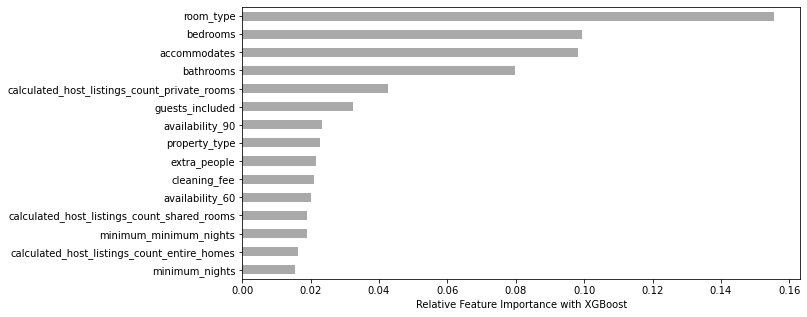

In [24]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=df.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');


In [25]:
df['distance']

0         4.633575
1         3.533473
2         3.696110
3         3.755653
4         3.565951
           ...    
24546     2.565826
24547     0.991120
24548     3.090134
24549    18.421364
24550     3.518381
Name: distance, Length: 24348, dtype: float64

In [26]:
df_raw = pd.read_csv('listings.csv')

In [35]:
df_raw['space'][12346]

'The flat is in a quiet building in a lively area with bars, restaurants and supermarkets.  By subway you are in 20 minutes at Zoologischer Garten, Alexanderplatz or the Bundestag.  Close to the flat is food market every Tuesday and Friday. The flat provides a fast and stable WiFi connection, a washing Maschine, dishwasher, stove, fridge, shower and of course towels and linen.  In your room is a bed 2mx1,60m for two person and in the living room two sofas and a mattress.  You will have enough space to put all your clothes in the wardrobe or to hang your jackets and stuff.'